IMPORTING REQUIRED LIBRARIES

In [1]:
import tensorflow as tf
import os
import numpy
import cv2
import imghdr
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Softmax,Conv2D,MaxPooling2D,Flatten

In [2]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for i in gpus:
  tf.config.experimental.set_memory_growth(i,True)

In [3]:
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
exts=['jpg','jpeg','bmp','png']

In [6]:
dirr='/content/gdrive/MyDrive/image_classification'

In [7]:
for ic in os.listdir(dirr):
  for image in os.listdir(os.path.join(dirr,ic)):
    path=os.path.join(dirr,ic,image)
    try:
      img=cv2.imread(path)
      ext=imghdr.what(path)
      if ext not in exts:
        print('image not in ext list{}'.format(path))
        os.remove(path)
    except Exception as e:
      print('issue with image {}'.format(path))

data preprocessing and pipelining

In [82]:
data=tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/image_classification',batch_size=32)
iterator=data.as_numpy_iterator()
bt=iterator.next()
bt[1] # we are taking images in batches of 16 ; to reduce the computational costs as larger batch sizes are going to need more cpu perfomance

Found 397 files belonging to 4 classes.


array([3, 0, 0, 1, 3, 3, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 3, 1, 1, 0,
       1, 2, 0, 0, 0, 2, 0, 2, 1, 0], dtype=int32)

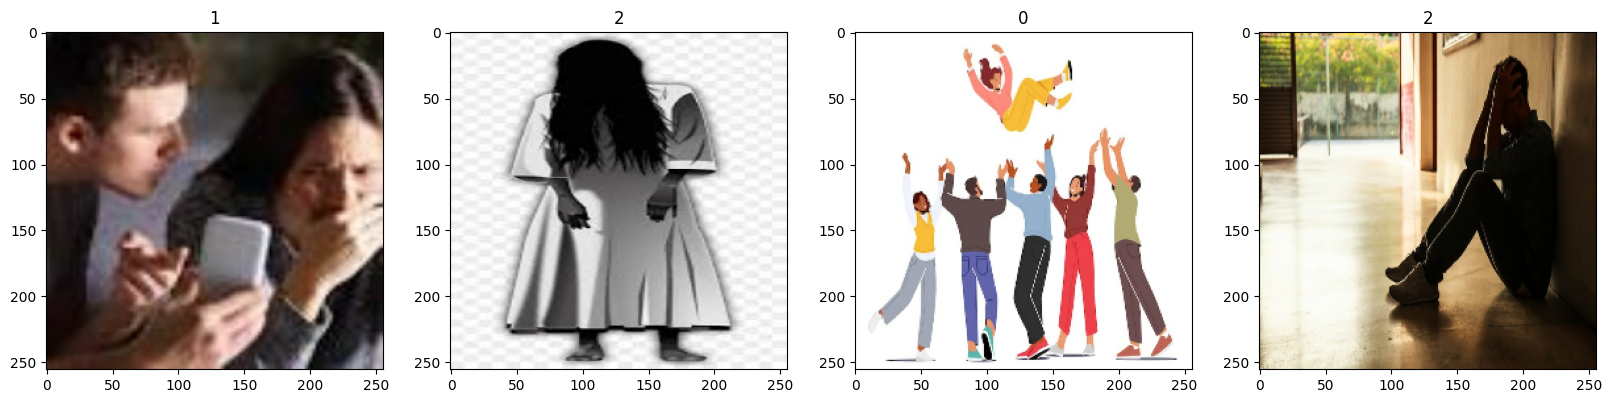

In [14]:
batch=iterator.next()
fig,ax=plt.subplots(figsize=(20,20),ncols=4)
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])
  #0-happy
  #1-jealous
  #2-sad
  #3-scared

In [83]:
data=data.map(lambda x,y:(x/255,y)) #scaling the pixel values to a value in between 0 and 1

In [86]:
data.as_numpy_iterator().next()[0].max

<built-in method max of numpy.ndarray object at 0x7effed167e10>


training testing and dev split 


In [12]:
train=data.take(int(len(data)*0.65)+1)
dev=data.skip(int(len(data)*0.65)+1).take(int(len(data)*0.25))
test=data.skip(int(len(data)*0.65)+1+int(len(data)*0.25)).take(int(len(data)*0.1))

In [13]:
len(train)+len(test)+len(dev)

13

In [67]:
model=Sequential()
metrics_list = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]

In [68]:
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=metrics_list
    )

In [69]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 16)      

In [70]:
log='/content/gdrive/MyDrive/log'

In [71]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log)

In [72]:
learn=model.fit(train,epochs=20,validation_data=dev,callbacks=[tensorboard_callback])

Epoch 1/20
9/9 [==============================] - 10s 538ms/step - loss: 1.5772 - accuracy: 0.2986 - val_loss: 1.3864 - val_accuracy: 0.3958
Epoch 2/20
9/9 [==============================] - 9s 699ms/step - loss: 1.3331 - accuracy: 0.3576 - val_loss: 1.3465 - val_accuracy: 0.3542
Epoch 3/20
9/9 [==============================] - 9s 794ms/step - loss: 1.2231 - accuracy: 0.4931 - val_loss: 1.0184 - val_accuracy: 0.5000
Epoch 4/20
9/9 [==============================] - 8s 599ms/step - loss: 0.9537 - accuracy: 0.6458 - val_loss: 0.7207 - val_accuracy: 0.8125
Epoch 5/20
9/9 [==============================] - 9s 676ms/step - loss: 0.7348 - accuracy: 0.7188 - val_loss: 0.5750 - val_accuracy: 0.8854
Epoch 6/20
9/9 [==============================] - 8s 636ms/step - loss: 0.6413 - accuracy: 0.8125 - val_loss: 0.4329 - val_accuracy: 0.8958
Epoch 7/20
9/9 [==============================] - 8s 588ms/step - loss: 0.3909 - accuracy: 0.8681 - val_loss: 0.2955 - val_accuracy: 0.9271
Epoch 8/20
9/9 [===

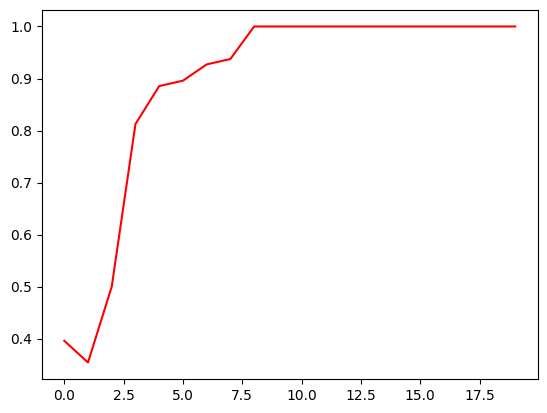

In [73]:
plt.plot(learn.history['val_accuracy'],color='red')
plt.show()

In [90]:
for batch in test.as_numpy_iterator():
  X,Y=batch 
  score = model.evaluate(X,Y, verbose=0)
  print(f'Test loss: {score[0]} / Test accuracy: {score[1]}') #evaluating model

Test loss: 0.00022764176537748426 / Test accuracy: 1.0


In [92]:
model.save('content/gdrive/MyDrive/image_classification/code')